Names:

Ethan Frias

Import Statements:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.multioutput import MultiOutputClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import hamming_loss
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

import pandas as pd
import io

Load training and test data.

In [ ]:
# IF RUNNING ON GOOGLE'S SERVERS USE THIS
# Load train.csv, test.csv, and test_labels.csv
# NOTE: Select ALL three files at once when uploading. It can take some time to execute
from google.colab import files
uploaded_files = files.upload()

training_csv = pd.read_csv(io.BytesIO(uploaded_files['train.csv']))
test_csv = pd.read_csv(io.BytesIO(uploaded_files['test.csv']))
test_labels_csv = pd.read_csv(io.BytesIO(uploaded_files['test_labels.csv']))

Saving test_labels.csv to test_labels.csv
Saving test.csv to test.csv
Saving train.csv to train.csv


In [2]:
# IF RUNNING ON LOCAL JUPYTER SERVER USE THIS
# Load train.csv, test.csv, and test_labels.csv
# NOTE: Change file paths if needed.
training_csv = pd.read_csv('Downloads/train.csv')
test_csv = pd.read_csv('Downloads/test.csv')
test_labels_csv = pd.read_csv('Downloads/test_labels.csv')

Reformat imported csv's into np arrays.

In [3]:
from ast import Str
# Training data
X_train = np.asarray(training_csv[training_csv.columns[1]])
Y_train = np.asarray(training_csv[training_csv.columns[2:]])

# Raw testing data
X_test_temp = np.asarray(test_csv[test_csv.columns[1]])
Y_test_temp = np.asarray(test_labels_csv[test_labels_csv.columns[1:]])

# Reformat the arrays since Y_test has -1 entries for some reason.
X_test = np.empty((len(X_test_temp)), dtype=object)
Y_test = np.empty((len(Y_test_temp), len(Y_test_temp[0])), dtype=np.int8)
size = 0

for i in range(len(Y_test_temp)):
  if Y_test_temp[i][0] < 0:
    continue
  X_test[size] = X_test_temp[i]
  Y_test[size] = Y_test_temp[i]
  size = size + 1
X_test = X_test[:size]
Y_test = Y_test[:size]

Create the learner.

In [4]:
toxic_learner = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=2500)),  # Count word frequency per document in a matrix.
    ('clf', MultiOutputClassifier(LogisticRegression(max_iter=200,class_weight={0:3, 1:1}))), # Use a classifier w/ multilabel output.
])
# Note: MLPClassifier does not work for this project. Training time is several hours long with just 10 hidden nodes.
# Likely due to huge quantity and dimensionality of data.

In [5]:
toxic_learner.fit(X_train, Y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=2500)),
                ('clf',
                 MultiOutputClassifier(estimator=LogisticRegression(class_weight={0: 3,
                                                                                  1: 1},
                                                                    max_iter=200)))])

In [ ]:
temp_vectorizer = TfidfVectorizer()
temp_vectorizer.fit(X_train)
temp_vectorizer.transform(X_train).shape

(159571, 189775)

In [ ]:
temp_vectorizer = TfidfVectorizer(max_features=1500)
temp_vectorizer.fit(X_train)
temp_vectorizer.transform(X_train).shape

(159571, 1500)

In [ ]:
temp_vectorizer.vocabulary_['fuck']

560

In [7]:
# Function for manual input and response.
types = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

def predict_toxic_type(comment: str) -> str:
  predictions = toxic_learner.predict([comment])[0]
  return_str = "Predicted Types: "
  num_predictions = 0
  for i in range(len(predictions)):
    if predictions[i] > 0:
      return_str = return_str + types[i] + ", "
      num_predictions = num_predictions + 1
  if num_predictions == 0:
    return_str = return_str + "None"
  return return_str

In [8]:
print(predict_toxic_type("hi hows it going"))
print(predict_toxic_type("bitch"))
print(predict_toxic_type("dude omg can you shut the fuck up"))
print(predict_toxic_type("go away"))
print(predict_toxic_type("im gonna go have sex with your mom and you cant stop me"))
print(predict_toxic_type("idiot"))
print(predict_toxic_type("dude why are you so bad"))
print(predict_toxic_type("fuck"))
print(predict_toxic_type("crap"))
print(predict_toxic_type("poop"))
print(predict_toxic_type("stupid"))

Predicted Types: None
Predicted Types: toxic, obscene, insult, 
Predicted Types: toxic, obscene, insult, 
Predicted Types: None
Predicted Types: toxic, 
Predicted Types: toxic, obscene, insult, 
Predicted Types: None
Predicted Types: toxic, obscene, insult, 
Predicted Types: toxic, obscene, 
Predicted Types: None
Predicted Types: toxic, obscene, insult, 


# Default Parameter Accuracy Testing

In [9]:
Y_hat_train = toxic_learner.predict(X_train)
Y_hat_test = toxic_learner.predict(X_test)

In [10]:
# Uses a hamming loss, meaning the percentage each pair of returned values is wrong.
# Lower is better.
# 0.03452 for MultinomialNB()
# 0.02502 for LogisticRegression() but seems to perform better with manual inputs than the MultinomialNB()
# 0.02589 for SGDClassifier(), same manual performance as LogisticRegression()
print("Training Loss: ", round(hamming_loss(Y_train, Y_hat_train),5))
print("Testing Loss: ", round(hamming_loss(Y_test, Y_hat_test),5))

print("\nAccuracy Per Label:")
for label in range(0,6):
  print("Label: " + types[label])
  print("Training Loss: ", round(hamming_loss(Y_train[:,label], Y_hat_train[:,label]),5))
  print("Testing Loss: ", round(hamming_loss(Y_test[:,label], Y_hat_test[:,label]),5))
  print("Confusion Matrix: \n", confusion_matrix(Y_test[:,label], Y_hat_test[:,label], normalize='all'))
  print()

Training Loss:  0.02061
Testing Loss:  0.02529

Accuracy Per Label:
Label: toxic
Training Loss:  0.0472
Testing Loss:  0.06043
Confusion Matrix: 
 [[0.88471037 0.02010066]
 [0.04032636 0.05486261]]

Label: severe_toxic
Training Loss:  0.00949
Testing Loss:  0.00567
Confusion Matrix: 
 [[9.93700960e-01 5.62693426e-04]
 [5.11113195e-03 6.25214918e-04]]

Label: obscene
Training Loss:  0.02435
Testing Loss:  0.03396
Confusion Matrix: 
 [[0.93649379 0.0058145 ]
 [0.0281503  0.0295414 ]]

Label: threat
Training Loss:  0.00269
Testing Loss:  0.00303
Confusion Matrix: 
 [[9.96576948e-01 1.25042984e-04]
 [2.90724937e-03 3.90759324e-04]]

Label: insult
Training Loss:  0.03184
Testing Loss:  0.03836
Confusion Matrix: 
 [[0.94305855 0.00337616]
 [0.03498077 0.01858451]]

Label: identity_hate
Training Loss:  0.0081
Testing Loss:  0.0103
Confusion Matrix: 
 [[9.88402263e-01 4.68911188e-04]
 [9.83150458e-03 1.29732095e-03]]



## Testing various max_features for TfidfVectorizer()

In [ ]:
# Max features set to powers of 2.
max_features = []
for i in range(5, 18):
  max_features.append(2**i)
hammingError_train = []
hammingError_test = []

for i in max_features:
  learner = Pipeline([
      ('tfidf', TfidfVectorizer(max_features=i)),  # Count word frequency per document in a matrix.
      ('clf', MultiOutputClassifier(LogisticRegression(max_iter=200))), # Use a classifier w/ multilabel output.
  ])
  # Fit the learner.
  learner.fit(X_train, Y_train)
  # Predict values.
  Y_hat_train = learner.predict(X_train)
  Y_hat_test = learner.predict(X_test)
  # Calculate hamming error.
  hammingError_train.append(hamming_loss(Y_train, Y_hat_train))
  hammingError_test.append(hamming_loss(Y_test, Y_hat_test))

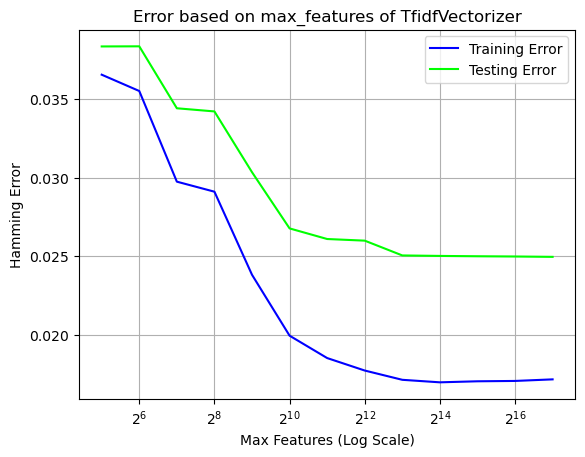

In [ ]:
# Plot results
fig, ax = plt.subplots(1,1)
ax.semilogx(max_features, hammingError_train, c="#0000FF", label="Training Error", base=2)
ax.semilogx(max_features, hammingError_test, c="#00FF00", label="Testing Error", base=2)
ax.set_title("Error based on max_features of TfidfVectorizer")
ax.set_xlabel("Max Features (Log Scale)")
ax.set_ylabel("Hamming Error")
ax.legend()
ax.grid()

Based on the above it seems setting max_features just causes the model to underfit due to testing error constantly decreasing and never reaching a relative minima.

## Testing various max_features for CountVectorizer()

In [ ]:
# Max features set to powers of 2.
max_features = []
for i in range(5, 18):
  max_features.append(2**i)
hammingError_train = []
hammingError_test = []

for i in max_features:
  learner = Pipeline([
      ('tfidf', CountVectorizer(max_features=i)),  # Count word frequency per document in a matrix.
      ('clf', MultiOutputClassifier(LogisticRegression(max_iter=200))), # Use a classifier w/ multilabel output.
  ])
  # Fit the learner.
  learner.fit(X_train, Y_train)
  # Predict values.
  Y_hat_train = learner.predict(X_train)
  Y_hat_test = learner.predict(X_test)
  # Calculate hamming error.
  hammingError_train.append(hamming_loss(Y_train, Y_hat_train))
  hammingError_test.append(hamming_loss(Y_test, Y_hat_test))

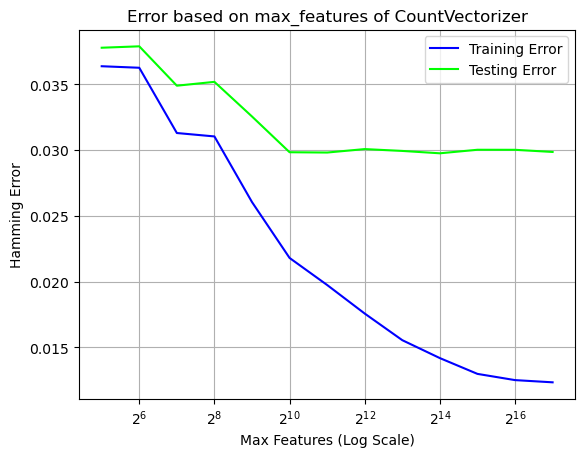

In [ ]:
# Plot results
fig, ax = plt.subplots(1,1)
ax.semilogx(max_features, hammingError_train, c="#0000FF", label="Training Error", base=2)
ax.semilogx(max_features, hammingError_test, c="#00FF00", label="Testing Error", base=2)
ax.set_title("Error based on max_features of CountVectorizer")
ax.set_xlabel("Max Features (Log Scale)")
ax.set_ylabel("Hamming Error")
ax.legend()
ax.grid()

# Capitalization Accuracy Testing

In [ ]:
# Use capitalization for generating features.
force_lowercase = [True, False]
hammingError_train = []
hammingError_test = []

for i in force_lowercase:
  learner = Pipeline([
      ('tfidf', TfidfVectorizer(lowercase=i)),  # Count word frequency per document in a matrix.
      ('clf', MultiOutputClassifier(LogisticRegression(max_iter=200))), # Use a classifier w/ multilabel output.
  ])
  # Fit the learner.
  learner.fit(X_train, Y_train)
  # Predict values.
  Y_hat_train = learner.predict(X_train)
  Y_hat_test = learner.predict(X_test)
  # Calculate hamming error.
  hammingError_train.append(hamming_loss(Y_train, Y_hat_train))
  hammingError_test.append(hamming_loss(Y_test, Y_hat_test))

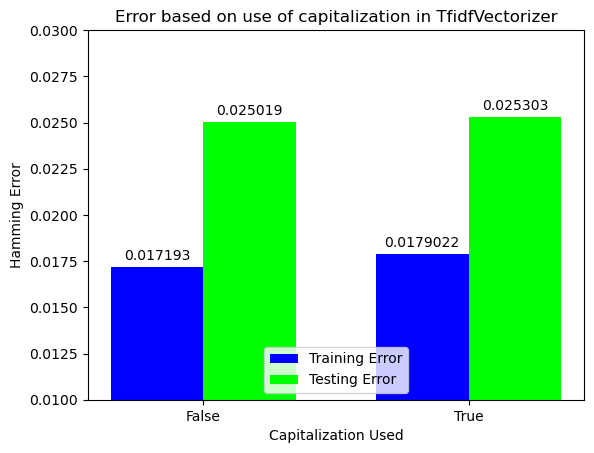

In [ ]:
# Plot results
use_capitalization = ["False", "True"]
x = np.arange(len(use_capitalization))
fig, ax = plt.subplots(1,1)
training_rect = ax.bar(x, hammingError_train, color="#0000FF", label="Training Error", width = 0.35)
testing_rect = ax.bar(x + 0.35, hammingError_test, color="#00FF00", label="Testing Error", width = 0.35)
ax.bar_label(training_rect, padding=3)
ax.bar_label(testing_rect, padding=3)
ax.set_title("Error based on use of capitalization in TfidfVectorizer")
ax.set_xlabel("Capitalization Used")
ax.set_ylabel("Hamming Error")
ax.set_ylim(0.01,0.03)
ax.set_xticks(x + 0.175, use_capitalization)
ax.legend(loc='lower center')

Based on the above attempting to use capitalization in training, despite the implications on tone, makes the accuracy overall slightly worst.

# Removing accents accuracy.

In [ ]:
# Strip accents for generating features.
strip_accents = [None, 'ascii', 'unicode']
hammingError_train = []
hammingError_test = []

for i in strip_accents:
  learner = Pipeline([
      ('tfidf', TfidfVectorizer(strip_accents=i)),  # Count word frequency per document in a matrix.
      ('clf', MultiOutputClassifier(LogisticRegression(max_iter=200))), # Use a classifier w/ multilabel output.
  ])
  # Fit the learner.
  learner.fit(X_train, Y_train)
  # Predict values.
  Y_hat_train = learner.predict(X_train)
  Y_hat_test = learner.predict(X_test)
  # Calculate hamming error.
  hammingError_train.append(hamming_loss(Y_train, Y_hat_train))
  hammingError_test.append(hamming_loss(Y_test, Y_hat_test))

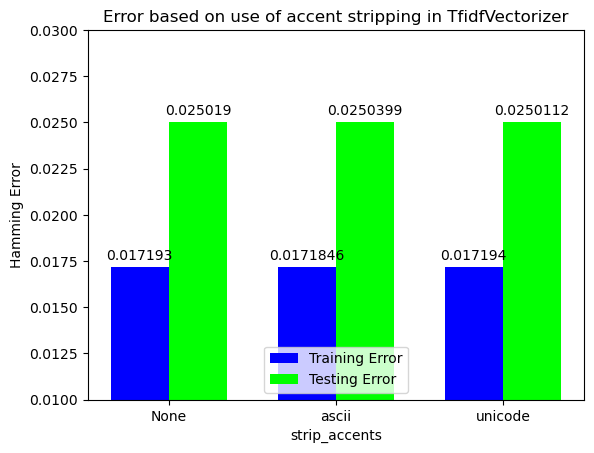

In [ ]:
# Plot results
strip_accents_str = ['None','ascii', 'unicode']
x = np.arange(len(strip_accents_str))
fig, ax = plt.subplots(1,1)
training_rect = ax.bar(x, hammingError_train, color="#0000FF", label="Training Error", width = 0.35)
testing_rect = ax.bar(x + 0.35, hammingError_test, color="#00FF00", label="Testing Error", width = 0.35)
ax.bar_label(training_rect, padding=3)
ax.bar_label(testing_rect, padding=3)
ax.set_title("Error based on use of accent stripping in TfidfVectorizer")
ax.set_xlabel("strip_accents")
ax.set_ylabel("Hamming Error")
ax.set_ylim(0.01,0.03)
ax.set_xticks(x + 0.175, strip_accents_str)
ax.legend(loc='lower center')

Stripping accents had practically no effect on our data. If our data included multiple languages outside of english this might've been more effective.

# Max Document Frequency Accuracy

In [ ]:
# Max_df set to powers of 0.7.
max_df = []
for i in range(0, 11):
  max_df.append(0.7**(i))
hammingError_train = []
hammingError_test = []

for i in max_df:
  learner = Pipeline([
      ('tfidf', TfidfVectorizer(max_df=i)),  # Count word frequency per document in a matrix.
      ('clf', MultiOutputClassifier(LogisticRegression())), # Use a classifier w/ multilabel output.
  ])
  # Fit the learner.
  learner.fit(X_train, Y_train)
  # Predict values.
  Y_hat_train = learner.predict(X_train)
  Y_hat_test = learner.predict(X_test)
  # Calculate hamming error.
  hammingError_train.append(hamming_loss(Y_train, Y_hat_train))
  hammingError_test.append(hamming_loss(Y_test, Y_hat_test))

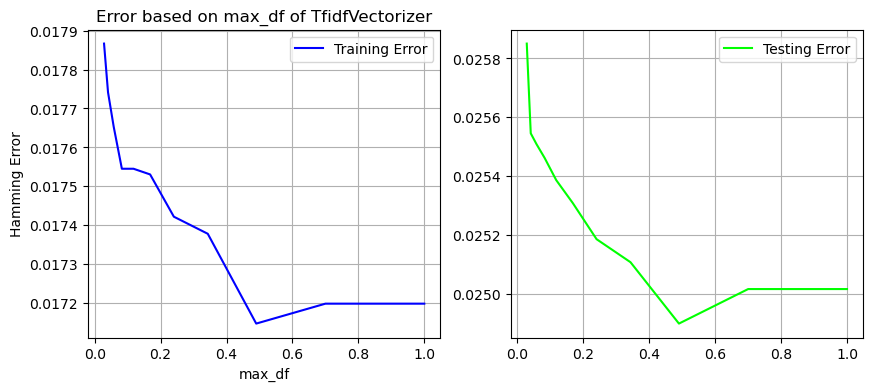

In [ ]:
# Plot results
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(max_df, hammingError_train, c="#0000FF", label="Training Error")
ax[1].plot(max_df, hammingError_test, c="#00FF00", label="Testing Error")
ax[0].set_title("Error based on max_df of TfidfVectorizer")
ax[0].set_xlabel("max_df")
ax[0].set_ylabel("Hamming Error")
ax[0].legend()
ax[1].legend()
ax[0].grid()
ax[1].grid()

Interestingly enough the accuracy decreases slightly with low enough max_df values but is slightly more accurate than the default max_df = 1.0 around max_df = 0.5. This also shows that common words have very little influence over our model's accuracy.

# More precise analysis of max document frequency accuracy.

In [ ]:
# Max_df set to powers of 0.7.
max_df = np.arange(0.4,0.7,0.02)
hammingError_train = []
hammingError_test = []

for i in max_df:
  learner = Pipeline([
      ('tfidf', TfidfVectorizer(max_df=i)),  # Count word frequency per document in a matrix.
      ('clf', MultiOutputClassifier(LogisticRegression(max_iter=200))), # Use a classifier w/ multilabel output.
  ])
  # Fit the learner.
  learner.fit(X_train, Y_train)
  # Predict values.
  Y_hat_train = learner.predict(X_train)
  Y_hat_test = learner.predict(X_test)
  # Calculate hamming error.
  hammingError_train.append(hamming_loss(Y_train, Y_hat_train))
  hammingError_test.append(hamming_loss(Y_test, Y_hat_test))

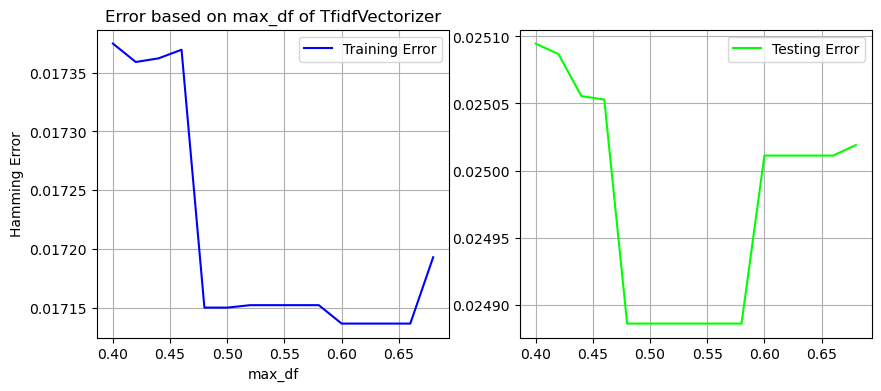

In [ ]:
# Plot results
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(max_df, hammingError_train, c="#0000FF", label="Training Error")
ax[1].plot(max_df, hammingError_test, c="#00FF00", label="Testing Error")
ax[0].set_title("Error based on max_df of TfidfVectorizer")
ax[0].set_xlabel("max_df")
ax[0].set_ylabel("Hamming Error")
ax[0].legend()
ax[1].legend()
ax[0].grid()
ax[1].grid()

Very interestingly the best results happen very suddenly between 0.48 and 0.6. However they're very slightly better and likely not worth implementing.

# Min Document Frequency Accuracy
Will think this will have similar performance to max_features.

In [ ]:
# min_df
min_df = np.arange(0.0,0.6,0.1)
hammingError_train = []
hammingError_test = []

for i in min_df:
  learner = Pipeline([
      ('tfidf', TfidfVectorizer(min_df=i)),  # Count word frequency per document in a matrix.
      ('clf', MultiOutputClassifier(LogisticRegression())), # Use a classifier w/ multilabel output.
  ])
  # Fit the learner.
  learner.fit(X_train, Y_train)
  # Predict values.
  Y_hat_train = learner.predict(X_train)
  Y_hat_test = learner.predict(X_test)
  # Calculate hamming error.
  hammingError_train.append(hamming_loss(Y_train, Y_hat_train))
  hammingError_test.append(hamming_loss(Y_test, Y_hat_test))

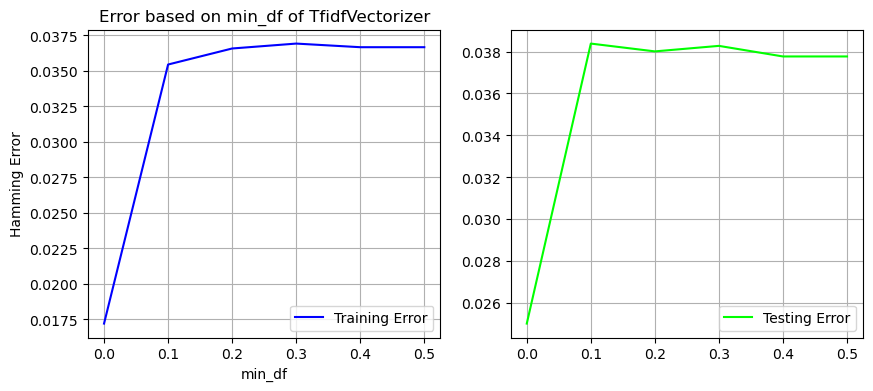

In [ ]:
# Plot results
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(min_df, hammingError_train, c="#0000FF", label="Training Error")
ax[1].plot(min_df, hammingError_test, c="#00FF00", label="Testing Error")
ax[0].set_title("Error based on min_df of TfidfVectorizer")
ax[0].set_xlabel("min_df")
ax[0].set_ylabel("Hamming Error")
ax[0].legend()
ax[1].legend()
ax[0].grid()
ax[1].grid()

As expected results were similar to max_features where we'd want to use the most possible, or the default option. However, this decreased performance much more rapidly than max_features, implying rare words are very important for toxicity classification.

# Testing Logistic Regression Solver Accuracy

In [ ]:
# Use various solvers.
lr_solvers = ['lbfgs','liblinear', 'newton-cg', 'sag', 'saga']
hammingError_train = []
hammingError_test = []

for i in lr_solvers:
  learner = Pipeline([
      ('tfidf', TfidfVectorizer()),  # Count word frequency per document in a matrix.
      ('clf', MultiOutputClassifier(LogisticRegression(solver=i))), # Use a classifier w/ multilabel output.
  ])
  # Fit the learner.
  learner.fit(X_train, Y_train)
  # Predict values.
  Y_hat_train = learner.predict(X_train)
  Y_hat_test = learner.predict(X_test)
  # Calculate hamming error.
  hammingError_train.append(hamming_loss(Y_train, Y_hat_train))
  hammingError_test.append(hamming_loss(Y_test, Y_hat_test))

C:\Users\ethan\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


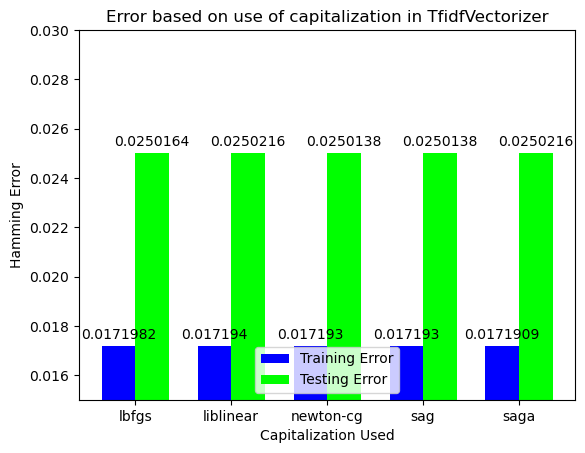

In [ ]:
# Plot results
x = np.arange(len(lr_solvers))
fig, ax = plt.subplots(1,1)
training_rect = ax.bar(x, hammingError_train, color="#0000FF", label="Training Error", width = 0.35)
testing_rect = ax.bar(x + 0.35, hammingError_test, color="#00FF00", label="Testing Error", width = 0.35)
ax.bar_label(training_rect, padding=3)
ax.bar_label(testing_rect, padding=3)
ax.set_title("Logistic Regression Solver Accuracy")
ax.set_xlabel("Solver Used")
ax.set_ylabel("Hamming Error")
ax.set_ylim(0.015,0.03)
ax.set_xticks(x + 0.175, lr_solvers)
ax.legend(loc='upper center')

The various solvers had no affect on the accuracy.

# Class weights

In [ ]:
# Use various solvers.
lr_class_weights = [None,'balanced', {0 : 1, 1 : 10}, {0 : 10, 1 : 1}]
hammingError_train = []
hammingError_test = []

for i in lr_class_weights:
  learner = Pipeline([
      ('tfidf', TfidfVectorizer()),  # Count word frequency per document in a matrix.
      ('clf', MultiOutputClassifier(LogisticRegression(class_weight=i))), # Use a classifier w/ multilabel output.
  ])
  # Fit the learner.
  learner.fit(X_train, Y_train)
  # Predict values.
  Y_hat_train = learner.predict(X_train)
  Y_hat_test = learner.predict(X_test)
  # Calculate hamming error.
  hammingError_train.append(hamming_loss(Y_train, Y_hat_train))
  hammingError_test.append(hamming_loss(Y_test, Y_hat_test))

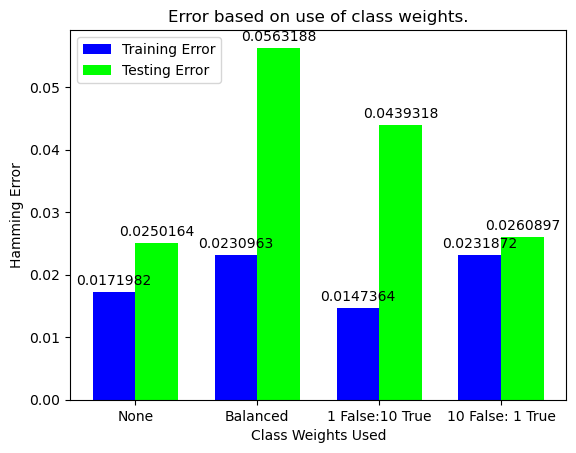

In [ ]:
# Plot results
lr_class_weights_str = ['None','Balanced','1 False:10 True', '10 False: 1 True']
x = np.arange(len(lr_class_weights))
fig, ax = plt.subplots(1,1)
training_rect = ax.bar(x, hammingError_train, color="#0000FF", label="Training Error", width = 0.35)
testing_rect = ax.bar(x + 0.35, hammingError_test, color="#00FF00", label="Testing Error", width = 0.35)
ax.bar_label(training_rect, padding=3)
ax.bar_label(testing_rect, padding=3)
ax.set_title("Error based on use of class weights.")
ax.set_xlabel("Class Weights Used")
ax.set_ylabel("Hamming Error")
#ax.set_ylim(0.015,0.03)
ax.set_xticks(x + 0.175, lr_class_weights_str)
ax.legend(loc='upper left')

In [ ]:
for label in range(0,6):
  print("Label: " + types[label])
  print("Training Loss: ", round(hamming_loss(Y_train[:,label], Y_hat_train[:,label]),5))
  print("Testing Loss: ", round(hamming_loss(Y_test[:,label], Y_hat_test[:,label]),5))
  print("Confusion Matrix: \n", confusion_matrix(Y_test[:,label], Y_hat_test[:,label], normalize='all'))
  print()

Label: toxic
Training Loss:  0.0526
Testing Loss:  0.05814
Confusion Matrix: 
 [[0.89487011 0.00994092]
 [0.04820407 0.0469849 ]]

Label: severe_toxic
Training Loss:  0.00967
Testing Loss:  0.0056
Confusion Matrix: 
 [[9.94076089e-01 1.87564475e-04]
 [5.40810904e-03 3.28237832e-04]]

Label: obscene
Training Loss:  0.02852
Testing Loss:  0.03648
Confusion Matrix: 
 [[0.93946357 0.00284473]
 [0.03363656 0.02405514]]

Label: threat
Training Loss:  0.00281
Testing Loss:  0.00313
Confusion Matrix: 
 [[9.96561318e-01 1.40673356e-04]
 [2.98540123e-03 3.12607459e-04]]

Label: insult
Training Loss:  0.03715
Testing Loss:  0.04267
Confusion Matrix: 
 [[0.94491857 0.00151615]
 [0.04115477 0.01241052]]

Label: identity_hate
Training Loss:  0.00837
Testing Loss:  0.01052
Confusion Matrix: 
 [[9.88699240e-01 1.71934102e-04]
 [1.03473069e-02 7.81518647e-04]]



In [ ]:
# class_weights
class_weights = range(1,11)
hammingError_train = []
hammingError_test = []

for i in class_weights:
  learner = Pipeline([
      ('tfidf', TfidfVectorizer()),  # Count word frequency per document in a matrix.
      ('clf', MultiOutputClassifier(LogisticRegression(max_iter=500,class_weight={0 : i, 1 : 1}))), # Use a classifier w/ multilabel output.
  ])
  # Fit the learner.
  learner.fit(X_train, Y_train)
  # Predict values.
  Y_hat_train = learner.predict(X_train)
  Y_hat_test = learner.predict(X_test)
  # Calculate hamming error.
  hammingError_train.append(hamming_loss(Y_train, Y_hat_train))
  hammingError_test.append(hamming_loss(Y_test, Y_hat_test))

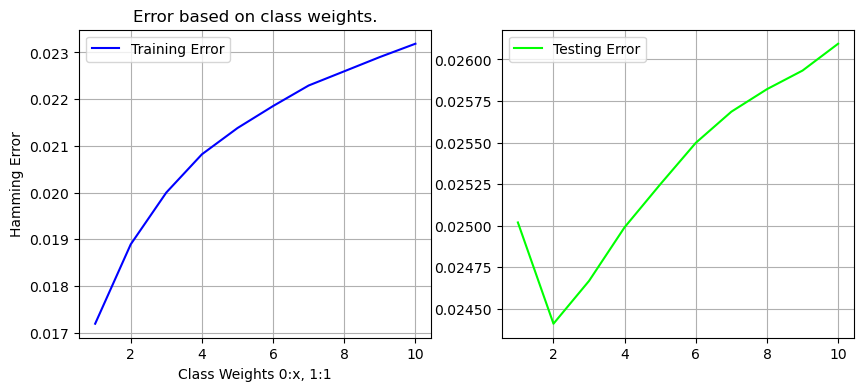

In [ ]:
# Plot results
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(class_weights, hammingError_train, c="#0000FF", label="Training Error")
ax[1].plot(class_weights, hammingError_test, c="#00FF00", label="Testing Error")
ax[0].set_title("Error based on class weights.")
ax[0].set_xlabel("Class Weights 0:x, 1:1")
ax[0].set_ylabel("Hamming Error")
ax[0].legend()
ax[1].legend()
ax[0].grid()
ax[1].grid()

Using various class weights can help adjust for false positives and false negatives, though for our data reducing false positives is far more important for a toxicity classifier, so using a dictionary that emphasises false values is best. However this increases the error of predictions given their true label is true. 2:1 produces the best results.

# max_iter Accuracy

In [ ]:
# Max features set to powers of 2.
max_iter = []
for i in range(0, 9):
  max_iter.append(10 * 2**i)
hammingError_train = []
hammingError_test = []

for i in max_iter:
  learner = Pipeline([
      ('tfidf', TfidfVectorizer()),  # Count word frequency per document in a matrix.
      ('clf', MultiOutputClassifier(LogisticRegression(max_iter=i))), # Use a classifier w/ multilabel output.
  ])
  # Fit the learner.
  learner.fit(X_train, Y_train)
  # Predict values.
  Y_hat_train = learner.predict(X_train)
  Y_hat_test = learner.predict(X_test)
  # Calculate hamming error.
  hammingError_train.append(hamming_loss(Y_train, Y_hat_train))
  hammingError_test.append(hamming_loss(Y_test, Y_hat_test))

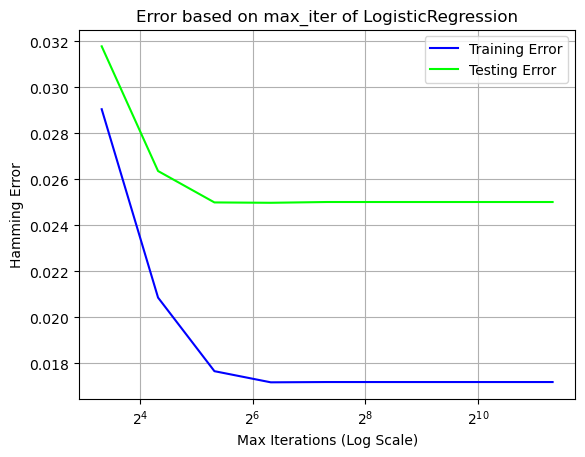

In [ ]:
# Plot results
fig, ax = plt.subplots(1,1)
ax.semilogx(max_iter, hammingError_train, c="#0000FF", label="Training Error", base=2)
ax.semilogx(max_iter, hammingError_test, c="#00FF00", label="Testing Error", base=2)
ax.set_title("Error based on max_iter of LogisticRegression")
ax.set_xlabel("Max Iterations (Log Scale)")
ax.set_ylabel("Hamming Error")
ax.legend()
ax.grid()

Naturally more iterations lead to a more accurate model. It levels out around the default of 100 iterations though so setting it to 200 likely will be a safeguard.

# Regularization Accuracy

In [ ]:
# Max features set to powers of 2.
regularization = []
for i in range(0, 8):
  regularization.append(0.0001 * 10**i)
hammingError_train = []
hammingError_test = []

for i in regularization:
  learner = Pipeline([
      ('tfidf', TfidfVectorizer()),  # Count word frequency per document in a matrix.
      ('clf', MultiOutputClassifier(LogisticRegression(max_iter=200, C=i))), # Use a classifier w/ multilabel output.
  ])
  # Fit the learner.
  learner.fit(X_train, Y_train)
  # Predict values.
  Y_hat_train = learner.predict(X_train)
  Y_hat_test = learner.predict(X_test)
  # Calculate hamming error.
  hammingError_train.append(hamming_loss(Y_train, Y_hat_train))
  hammingError_test.append(hamming_loss(Y_test, Y_hat_test))

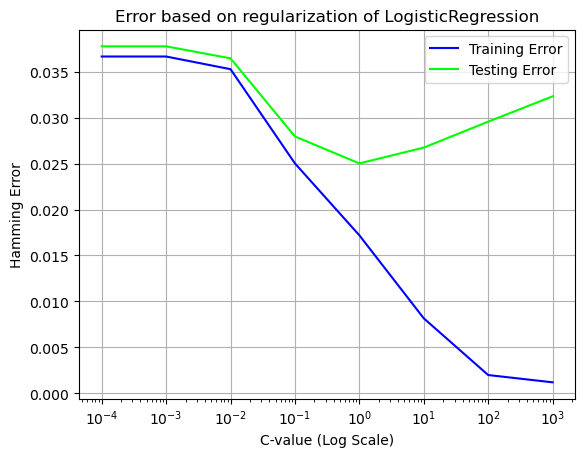

In [ ]:
# Plot results
fig, ax = plt.subplots(1,1)
ax.semilogx(regularization, hammingError_train, c="#0000FF", label="Training Error", base=10)
ax.semilogx(regularization, hammingError_test, c="#00FF00", label="Testing Error", base=10)
ax.set_title("Error based on regularization of LogisticRegression")
ax.set_xlabel("C-value (Log Scale)")
ax.set_ylabel("Hamming Error")
ax.legend()
ax.grid()

The default value c=1.0 has shown to be the best regularlization value.

# Effect of StandardScaler

In [ ]:
hammingError_train = []
hammingError_test = []

# No scaler
learner = Pipeline([
    ('tfidf', TfidfVectorizer()),  # Count word frequency per document in a matrix.
    ('clf', MultiOutputClassifier(LogisticRegression(max_iter=200))), # Use a classifier w/ multilabel output.
])
# Fit the learner.
learner.fit(X_train, Y_train)
# Predict values.
Y_hat_train = learner.predict(X_train)
Y_hat_test = learner.predict(X_test)
# Calculate hamming error.
hammingError_train.append(hamming_loss(Y_train, Y_hat_train))
hammingError_test.append(hamming_loss(Y_test, Y_hat_test))

# With scaler
learner = Pipeline([
    ('tfidf', TfidfVectorizer()),  # Count word frequency per document in a matrix.
    ('stdscale', StandardScaler(with_mean=False)),
    ('clf', MultiOutputClassifier(LogisticRegression(max_iter=200))), # Use a classifier w/ multilabel output.
])
# Fit the learner.
learner.fit(X_train, Y_train)
# Predict values.
Y_hat_train = learner.predict(X_train)
Y_hat_test = learner.predict(X_test)
# Calculate hamming error.
hammingError_train.append(hamming_loss(Y_train, Y_hat_train))
hammingError_test.append(hamming_loss(Y_test, Y_hat_test))

# With scaler & max_df
learner = Pipeline([
    ('tfidf', TfidfVectorizer(max_df=0.02)),  # Count word frequency per document in a matrix.
    ('stdscale', StandardScaler(with_mean=False)),
    ('clf', MultiOutputClassifier(LogisticRegression(max_iter=200))), # Use a classifier w/ multilabel output.
])
# Fit the learner.
learner.fit(X_train, Y_train)
# Predict values.
Y_hat_train = learner.predict(X_train)
Y_hat_test = learner.predict(X_test)
# Calculate hamming error.
hammingError_train.append(hamming_loss(Y_train, Y_hat_train))
hammingError_test.append(hamming_loss(Y_test, Y_hat_test))

# With scaler & class weights
learner = Pipeline([
    ('tfidf', TfidfVectorizer()),  # Count word frequency per document in a matrix.
    ('stdscale', StandardScaler(with_mean=False)),
    ('clf', MultiOutputClassifier(LogisticRegression(max_iter=200,class_weight={0:3,1:1}))), # Use a classifier w/ multilabel output.
])
# Fit the learner.
learner.fit(X_train, Y_train)
# Predict values.
Y_hat_train = learner.predict(X_train)
Y_hat_test = learner.predict(X_test)
# Calculate hamming error.
hammingError_train.append(hamming_loss(Y_train, Y_hat_train))
hammingError_test.append(hamming_loss(Y_test, Y_hat_test))

C:\Users\ethan\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ethan\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

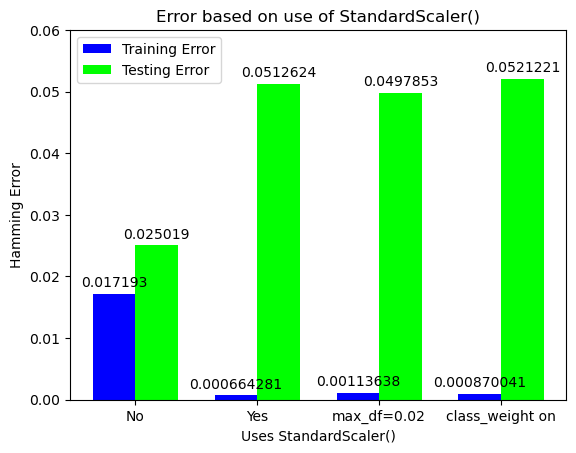

In [ ]:
# Plot results
uses_scaler = ["No", "Yes", "max_df=0.02", "class_weight on"]
x = np.arange(len(uses_scaler))
fig, ax = plt.subplots(1,1)
training_rect = ax.bar(x, hammingError_train, color="#0000FF", label="Training Error", width = 0.35)
testing_rect = ax.bar(x + 0.35, hammingError_test, color="#00FF00", label="Testing Error", width = 0.35)
ax.bar_label(training_rect, padding=3)
ax.bar_label(testing_rect, padding=3)
ax.set_title("Error based on use of StandardScaler()")
ax.set_xlabel("Uses StandardScaler()")
ax.set_ylabel("Hamming Error")
ax.set_ylim(0.0,0.06)
ax.set_xticks(x + 0.175, uses_scaler)
ax.legend(loc='upper left')

Based on above, using StandardScaler() causes the model to overfit. There is a slight improvement in performance when we apply max_df to the model to try to offset StandardScaler()'s variance adjustment of words.

# Standard Scaler & max_df/class_weight

In [ ]:
max_df = np.arange(0.01,0.1,0.01)
hammingError_train = []
hammingError_test = []

for i in max_df:
  learner = Pipeline([
      ('tfidf', TfidfVectorizer(max_df=i)),  # Count word frequency per document in a matrix.
      ('stdscale', StandardScaler(with_mean=False)),
      ('clf', MultiOutputClassifier(LogisticRegression(max_iter=200))), # Use a classifier w/ multilabel output.
  ])
  # Fit the learner.
  learner.fit(X_train, Y_train)
  # Predict values.
  Y_hat_train = learner.predict(X_train)
  Y_hat_test = learner.predict(X_test)
  # Calculate hamming error.
  hammingError_train.append(hamming_loss(Y_train, Y_hat_train))
  hammingError_test.append(hamming_loss(Y_test, Y_hat_test))

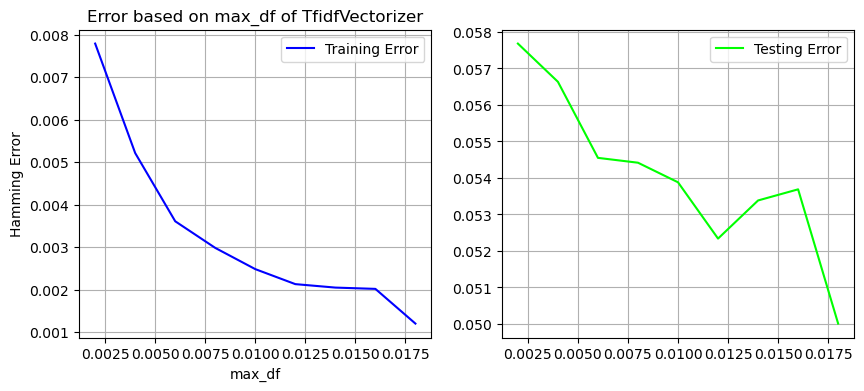

In [ ]:
# Plot results
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(max_df, hammingError_train, c="#0000FF", label="Training Error")
ax[1].plot(max_df, hammingError_test, c="#00FF00", label="Testing Error")
ax[0].set_title("Error based on max_df of TfidfVectorizer")
ax[0].set_xlabel("max_df")
ax[0].set_ylabel("Hamming Error")
ax[0].legend()
ax[1].legend()
ax[0].grid()
ax[1].grid()

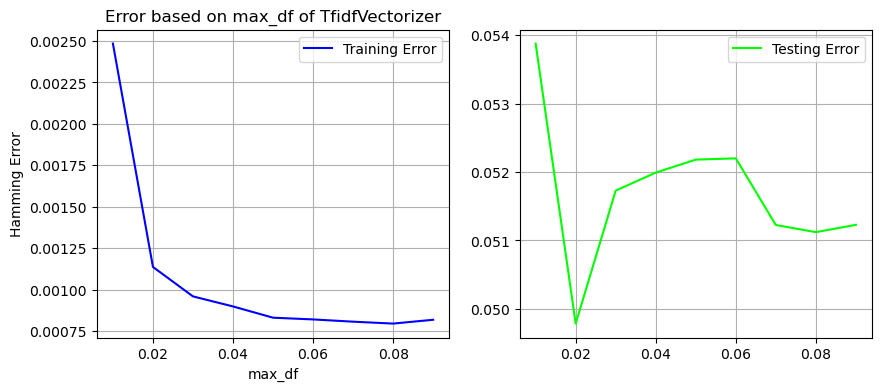

In [ ]:
# Plot results
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(max_df, hammingError_train, c="#0000FF", label="Training Error")
ax[1].plot(max_df, hammingError_test, c="#00FF00", label="Testing Error")
ax[0].set_title("Error based on max_df of TfidfVectorizer")
ax[0].set_xlabel("max_df")
ax[0].set_ylabel("Hamming Error")
ax[0].legend()
ax[1].legend()
ax[0].grid()
ax[1].grid()

max_df does not make enough of a difference with standard scalar.

# Standard Scaler and max_frequency of tf-idf

In [ ]:
# Max features set to powers of 2.
max_features = []
for i in range(5, 18):
  max_features.append(2**i)
hammingError_train = []
hammingError_test = []

for i in max_features:
  learner = Pipeline([
      ('tfidf', TfidfVectorizer(max_features=i)),  # Count word frequency per document in a matrix.
      ('scaler', StandardScaler(with_mean=False)),
      ('clf', MultiOutputClassifier(LogisticRegression(max_iter=200))), # Use a classifier w/ multilabel output.
  ])
  # Fit the learner.
  learner.fit(X_train, Y_train)
  # Predict values.
  Y_hat_train = learner.predict(X_train)
  Y_hat_test = learner.predict(X_test)
  # Calculate hamming error.
  hammingError_train.append(hamming_loss(Y_train, Y_hat_train))
  hammingError_test.append(hamming_loss(Y_test, Y_hat_test))

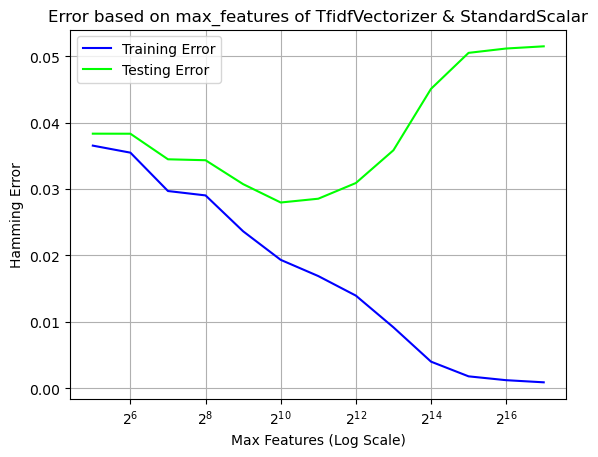

In [ ]:
# Plot results
fig, ax = plt.subplots(1,1)
ax.semilogx(max_features, hammingError_train, c="#0000FF", label="Training Error", base=2)
ax.semilogx(max_features, hammingError_test, c="#00FF00", label="Testing Error", base=2)
ax.set_title("Error based on max_features of TfidfVectorizer & StandardScalar")
ax.set_xlabel("Max Features (Log Scale)")
ax.set_ylabel("Hamming Error")
ax.legend()
ax.grid()

This is another indication that common words are not useful for classification. StandardScalar likely just evened out all words such that all words were considered to be the same frequency giving them too much importance in predictions. When max_features is low enough, the common word's arent considered anymore and StandardScalar becomes a hinderance.

# Standard Scaler and Bagging

In [ ]:
# Load data set
buckets = 50
temp_vectorizer = TfidfVectorizer(max_df=0.03)
temp_vectorizer.fit(X_train)
m,n = temp_vectorizer.transform(X_train).shape
classifiers = []

# Train models on subsets.
for i in range(buckets):
    ind = ((m/2) * np.random.rand(m)).astype(int)
    Xb, Yb = X_train[ind], Y_train[ind]
    learner = Pipeline([
      ('tfidf', TfidfVectorizer(max_df=0.02)),  # Count word frequency per document in a matrix.
      ('stdscale', StandardScaler(with_mean=False)),
      ('clf', MultiOutputClassifier(LogisticRegression(max_iter=200))), # Use a classifier w/ multilabel output.
    ])
    learner.fit(Xb, Yb)
    classifiers.append(learner)

y_hat_train = np.zeros( (temp_vectorizer.transform(X_train).shape[0], buckets, 6) )
y_hat_test = np.zeros( (temp_vectorizer.transform(X_test).shape[0], buckets, 6) )
for i in range(buckets):
    y_hat_train[:,i] = classifiers[i].predict(X_train)
    y_hat_test[:,i] = classifiers[i].predict(X_test)
print( "Training Error: " + str(hamming_loss((np.mean(y_hat_train, axis=1) > 0.5), Y_train)) )
print( "Testing Error: " + str(hamming_loss((np.mean(y_hat_test, axis=1) > 0.5), Y_test)) )

In [ ]:
def predict_toxic_type_bag(comment: str) -> str:
  predictions = np.zeros( (buckets, 6) )
  for i in range(buckets):
    predictions[i] = classifiers[i].predict([comment])
    predictions[i] = classifiers[i].predict([comment])
  predictions = np.mean(predictions, axis=0) > 0.5
  return_str = "Predicted Types: "
  num_predictions = 0
  for i in range(len(predictions)):
    if predictions[i]:
      return_str = return_str + types[i] + ", "
      num_predictions = num_predictions + 1
  if num_predictions == 0:
    return_str = return_str + "None"
  return return_str

In [ ]:
print(predict_toxic_type_bag("hi hows it going"))
print(predict_toxic_type_bag("bitch"))
print(predict_toxic_type_bag("dude omg can you shut the fuck up"))
print(predict_toxic_type_bag("go away"))
print(predict_toxic_type_bag("im gonna go have sex with your mom and you cant stop me"))
print(predict_toxic_type_bag("idiot"))
print(predict_toxic_type_bag("dude why are you so bad"))

Predicted Types: insult, identity_hate, 
Predicted Types: toxic, obscene, insult, 
Predicted Types: toxic, obscene, 
Predicted Types: None
Predicted Types: toxic, obscene, 
Predicted Types: toxic, obscene, insult, 
Predicted Types: None


With bagging the StandardScaler() still causes the model to overfit and takes signfificantly longer for predictions and training. Trying to find the right subset of randomly chosen data is very hard to get right and time consuming. Very easy for the model to still overfit even with bagging.

# MLPClassifier Alpha Testing

In [ ]:
# Max features set to powers of 10.
alpha_values = []
for i in range(-5, 2):
  alpha_values.append(10**i)
hammingError_train = []
hammingError_test = []

for i in alpha_values:
  learner = Pipeline([
      ('tfidf', TfidfVectorizer(max_features=2500)),  # Count word frequency per document in a matrix.
      ('clf', MultiOutputClassifier(MLPClassifier(hidden_layer_sizes=(50,20),alpha=i))), # Use a classifier w/ multilabel output.
  ])
  # Fit the learner.
  learner.fit(X_train, Y_train)
  # Predict values.
  Y_hat_train = learner.predict(X_train)
  Y_hat_test = learner.predict(X_test)
  # Calculate hamming error.
  hammingError_train.append(hamming_loss(Y_train, Y_hat_train))
  hammingError_test.append(hamming_loss(Y_test, Y_hat_test))

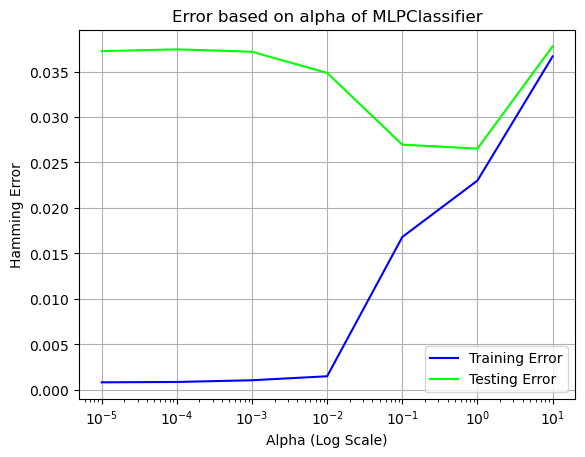

In [ ]:
# Plot results
fig, ax = plt.subplots(1,1)
ax.semilogx(alpha_values, hammingError_train, c="#0000FF", label="Training Error", base=10)
ax.semilogx(alpha_values, hammingError_test, c="#00FF00", label="Testing Error", base=10)
ax.set_title("Error based on alpha of MLPClassifier")
ax.set_xlabel("Alpha (Log Scale)")
ax.set_ylabel("Hamming Error")
ax.legend()
ax.grid()

In [11]:
# Max features set to powers of 10.
alpha_values = np.arange(0.02, 1.0, 0.06)
hammingError_train = []
hammingError_test = []

for i in alpha_values:
  learner = Pipeline([
      ('tfidf', TfidfVectorizer(max_features=2500)),  # Count word frequency per document in a matrix.
      ('clf', MultiOutputClassifier(MLPClassifier(hidden_layer_sizes=(50,20),alpha=i))), # Use a classifier w/ multilabel output.
  ])
  # Fit the learner.
  learner.fit(X_train, Y_train)
  # Predict values.
  Y_hat_train = learner.predict(X_train)
  Y_hat_test = learner.predict(X_test)
  # Calculate hamming error.
  hammingError_train.append(hamming_loss(Y_train, Y_hat_train))
  hammingError_test.append(hamming_loss(Y_test, Y_hat_test))

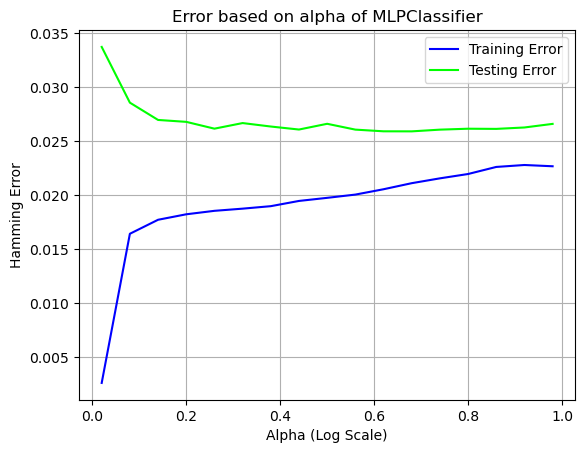

In [12]:
# Plot results
fig, ax = plt.subplots(1,1)
ax.plot(alpha_values, hammingError_train, c="#0000FF", label="Training Error")
ax.plot(alpha_values, hammingError_test, c="#00FF00", label="Testing Error")
ax.set_title("Error based on alpha of MLPClassifier")
ax.set_xlabel("Alpha (Log Scale)")
ax.set_ylabel("Hamming Error")
ax.legend()
ax.grid()

# MLPClassifier & Learning Rate

In [14]:
# Max features set to powers of 10.
learning_rates = [0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
hammingError_train = []
hammingError_test = []

for i in learning_rates:
  learner = Pipeline([
      ('tfidf', TfidfVectorizer(max_features=2500)),  # Count word frequency per document in a matrix.
      ('clf', MultiOutputClassifier(MLPClassifier(hidden_layer_sizes=(50,20),alpha=0.6,learning_rate_init=i))), # Use a classifier w/ multilabel output.
  ])
  # Fit the learner.
  learner.fit(X_train, Y_train)
  # Predict values.
  Y_hat_train = learner.predict(X_train)
  Y_hat_test = learner.predict(X_test)
  # Calculate hamming error.
  hammingError_train.append(hamming_loss(Y_train, Y_hat_train))
  hammingError_test.append(hamming_loss(Y_test, Y_hat_test))

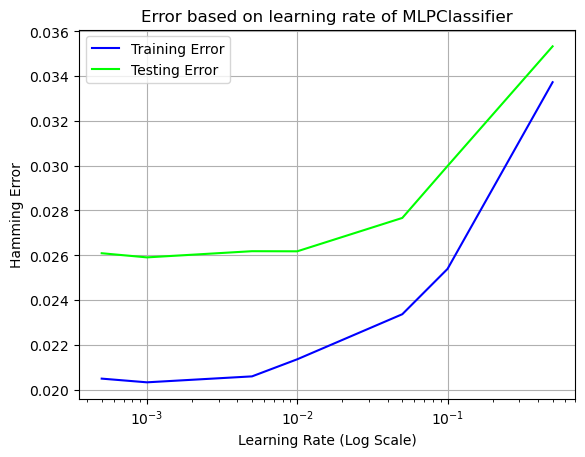

In [15]:
# Plot results
fig, ax = plt.subplots(1,1)
ax.semilogx(learning_rates, hammingError_train, c="#0000FF", label="Training Error", base=10)
ax.semilogx(learning_rates, hammingError_test, c="#00FF00", label="Testing Error", base=10)
ax.set_title("Error based on learning rate of MLPClassifier")
ax.set_xlabel("Learning Rate (Log Scale)")
ax.set_ylabel("Hamming Error")
ax.legend()
ax.grid()

# Overall Conclusions
The default parameters for the models have resulted in the best performance, with only around 2.46% of predicted labels being incorrect with a deliberate tendancy to have mostly false negatives. Additionally, overfitting and underfitting had noticable performance impacts as they made the detection of toxicity more and less sensitive respectively, as well as general incorrect answers. Error's with overfitting likely are due to being too confident in positive identification (false positives) while underfitting is a lack of confidence to positively identify (false negatives). Attempting to regularize data with StandardScaler() just caused extreme overfitting and overconfidence that couldn't be effectively countered with bagging.

The "toxic" label seems to be the hardest for the model to predict, it may be due to it being the most vague since a confusion matrix shows false positives and false negatives are about equal without any class weights. There is also very little data labeled as toxic with only about 10% of it or less having any label, especially identity_hate, severe_toxic, and threat with only around 1% of data being labeled with any.

Most output was also found to be dependent on some of the least common words found in the training data, mainly discovered through experiementing with TfidfVectorizer()'s max_df, min_df, and max_features parameters, however leaving out common words also negatively impacted performance slightly by underfitting.